### 🦥 Unsloth is growing! Come join us :)
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a>

Up to $500K USD salary + bonus equity, health care benefits + other benefits, USA relocation etc! Complete some puzzles and earn points!

* We encourage you to use AI for coding!<ins> No experience or PhD / Masters needed</ins> - just get enough points for consideration!
* There are <ins>negative points</ins> for incorrect submissions. Read each criteria! Read [Submission](#SUBMISSION) steps.

| Role              | Compensation   | Role Description | Points Needed |
| ----------------- | -------------- | ----------- | --- |
| Founding Engineer | \$400K to \$500K & equity | Help push Unsloth forward - bug fixes, core features, UI, kernels, nearly anything! | 47 |
| ML Engineer | \$250K to \$300K & equity | Help with FSDP2, Float8, Float4, kernels, Unsloth core and more! | 32 |
| ML Intern | up to \$150K py | Implementing specific features in Unsloth core. Can be remote.  | 18 |

1. [Convert `nf4` to Triton](#NF4) [Difficulty: Hard] [Max points: 14]
2. [Make `QLoRA` work with `FSDP2`](#FSDP2) [Difficulty: Medium to Hard] [Max points: 12]
3. [Make `torch.compile` work without graph breaks for QLoRA](#COMPILE) [Difficulty: Easy to Medium] [Max points: 9]
4. [Help solve 🦥 Unsloth issues!](#ISSUES) [Difficulty: Varies] [Max points: 12]
5. [Memory Efficient Backprop](#MATH) [Difficulty: Medium to Hard] [Max points: 10]
6. [Submission steps](#SUBMISSION)

### 🦥 Who are we?
* 1.58bit DeepSeek R1 GGUFs [Tweet](https://x.com/UnslothAI/status/1883899061893546254) and [HF Model Page](https://huggingface.co/unsloth/DeepSeek-R1-GGUF)
* GRPO Llama 3.1 8B on a free Colab [Tweet](https://x.com/UnslothAI/status/1887562753126408210)
* Gemma bug fixes [Tweet](https://x.com/danielhanchen/status/1765446273661075609) and bug fixes for Llama 3, Phi 3, Qwen 2.5 [Details](https://unsloth.ai/blog/phi3) Llama-fying Phi-4 [Details](https://unsloth.ai/blog/phi4)
* Gradient accumulation bug fixes [Tweet](https://x.com/danielhanchen/status/1846235913443262891) 4bit Dynamic Quantization [Details](https://unsloth.ai/blog/dynamic-4bit)
* Unsloth Gradient Checkpointing async offloads activations [Details](https://unsloth.ai/blog/long-context)
* 30K Github Stars [Github](https://github.com/unslothai/unsloth) & 7 million monthly downloads on [Hugging Face](https://huggingface.co/unsloth)
* PyTorch conference [video](https://www.youtube.com/watch?v=PdtKkc5jB4g) AI Engineer World's Fair [video](https://www.youtube.com/watch?v=pRM_P6UfdIc) GPU / CUDA MODE [talk](https://www.youtube.com/watch?v=hfb_AIhDYnA)


In [1]:
# Code to install Unsloth, Triton, Torch etc
# %%capture
# !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
# !pip install --no-deps cut_cross_entropy unsloth_zoo
# !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
# !pip install --no-deps unsloth

In [2]:
# Helpful functions used through the entire notebook
import torch
import torch.nn as nn
from transformers import set_seed
import time
import inspect
import os

major_version, minor_version = torch.cuda.get_device_capability()
HAS_BFLOAT16 = major_version >= 8
from inspect import currentframe as _C, getframeinfo

_F = lambda c: getframeinfo(c).lineno  # Gets line number
WARN = lambda x: print(f"\033[31m{x}\033[0m")  # Red colored warnings


# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
def NAME(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    return names[0] if len(names) != 0 else ""


def assert_same(x, y, line, dtype):
    assert x.dtype == dtype
    try:
        torch.testing.assert_close(x, y, check_stride=True)
    except Exception as error:
        raise RuntimeError(
            f"Failed allclose at line [{line}]: {NAME(x)}, {NAME(y)}\n{str(error)}"
        )


os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

---
---
---
<a name="NF4"></a>
## A) Convert `nf4` to Triton. [Difficulty: Hard] [Max points: 14]

1. Goal: Convert a `nf4` quantized tensor into `fp16` or `bf16` into a *single* Triton kernel The double dequant of the `absmax` and weight forming must be done in 1 Triton kernel. Must work on Tesla T4.
2. Must be faster than Unsloth's `fast_dequantize` by 1.15x or more, and not use large intermediate memory buffers.
3. Must not use `torch.compile`, but can use `trace.enabled` to help on writing Triton kernels.
4. Good material: [Unsloth `fast_dequantize` function](https://github.com/unslothai/unsloth/blob/main/unsloth/kernels/utils.py#L128), also [bitsandbytes `dequantize_blockwise`](https://github.com/bitsandbytes-foundation/bitsandbytes/blob/86b6c37a8ad448230cedb60753f63150b603a112/bitsandbytes/functional.py#L958)
5. Use `test_dequantize_function` to test your implementation.
6. No CUDA allowed. Custom CUDA inside of the Triton is allowed.
7. Watch Tim's videos on Youtube: [8-bit Optimizers](https://www.youtube.com/watch?v=2ETNONas068)

In [3]:
from bitsandbytes.nn import Linear4bit
from transformers.activations import ACT2FN
from unsloth.kernels.utils import fast_dequantize


def unsloth_dequantize(weight):
    return fast_dequantize(weight.weight, weight.weight.quant_state)


def bnb_Linear4bit(hd, m, dtype=torch.float16):
    return Linear4bit(
        hd,
        m,
        bias=None,
        compute_dtype=dtype,
        compress_statistics=True,
        quant_type="nf4",
    )


class MLP(nn.Module):
    def __init__(self, hd=4096, m=14336, dtype=torch.float16):
        super().__init__()
        self.gate_proj = bnb_Linear4bit(hd, m, dtype=dtype)
        self.up_proj = bnb_Linear4bit(hd, m, dtype=dtype)
        self.down_proj = bnb_Linear4bit(m, hd, dtype=dtype)
        self.act_fn = ACT2FN["silu"]

    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))


def mlp_forward(X, mlp, fx):
    up = X @ fx(mlp.up_proj).t()
    gate = X @ fx(mlp.gate_proj).t()
    h = mlp.act_fn(gate) * up
    down = h @ fx(mlp.down_proj).t()
    return down


def mlp_dequantize(X, mlp, fx):
    a = fx(mlp.up_proj).t()
    torch.cuda.synchronize()
    b = fx(mlp.gate_proj).t()
    torch.cuda.synchronize()
    c = fx(mlp.down_proj).t()
    torch.cuda.synchronize()
    return a, b, c


def test_dequantize(dequantize_fx):
    elapsed = 0
    options = [
        (5, 777, 1024, 4096, 3409, torch.bfloat16),
        (3, 2048, 4096, 14336, 3408, torch.bfloat16),
        (2, 3333, 2048, 8192, 3407, torch.float16),
    ]
    for bsz, qlen, hd, m, seed, dt in options:
        set_seed(seed)
        torch.set_default_dtype(dt)
        mlp = MLP(hd=hd, m=m, dtype=dt).to("cuda")
        X = torch.randn((bsz, qlen, hd), device="cuda")
        torch.cuda.synchronize()

        # Warmup
        for _ in range(2):
            assert_same(mlp_forward(X, mlp, dequantize_fx), mlp(X), _F(_C()), dt)
            a, b, c = mlp_dequantize(X, mlp, dequantize_fx)
            A, B, C = mlp_dequantize(X, mlp, unsloth_dequantize)
            assert_same(a, A, _F(_C()), dt)
            assert_same(b, B, _F(_C()), dt)
            assert_same(c, C, _F(_C()), dt)

        # Benchmarking
        torch.cuda.synchronize()
        start = time.time()
        for _ in range(1000):
            mlp_dequantize(X, mlp, dequantize_fx)
        elapsed += time.time() - start
    return elapsed

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


For example, we can test our implementation via:

In [4]:
from unsloth.kernels.utils import fast_dequantize


def unsloth_dequantize(weight):
    return fast_dequantize(weight.weight, weight.weight.quant_state)


test_dequantize(unsloth_dequantize)

2.214454174041748

The elapsed time for our implementation over 1000 trials is 5.38 seconds or so.

PEFT also has one, which should be mostly identical to Unsloth's version, albeit slightly slower.

In [5]:
from peft.utils.integrations import dequantize_module_weight as peft_dequantize

test_dequantize(peft_dequantize)

2.441948890686035

Write your Triton kernel below, and test it:

In [6]:
# from triton import jit
# import triton
# import triton.language as tl

# @triton.jit
# def _your_dequantize_nf4_kernel():
#     ### TRITON CODE GOES HERE
#     return

# def _your_dequantize_nf4(weight, quant_state):
#     ### SETUP TRITON LAUNCH HERE
#     return None

# def your_dequantize_nf4(weight):
#     return _your_dequantize_nf4(weight.weight.data, weight.weight.quant_state)

In [22]:
import triton
import triton.language as tl
from triton import jit


@triton.jit
def _your_dequantize_nf4_kernel(
    weight_ptr,  # [uint8]  Quantized weights, 1 byte => 2 NF4 elements
    absmax_ptr,  # [int]  One int "index" per element
    absmax2_ptr,  # [float]  One absmax2 per block
    code_ptr,  # [float]  NF4 code lookup
    code2_ptr,  # [float]  Absmax code lookup
    offset_ptr,  # [float]  Offset to add after absmax is decoded
    out_ptr,  # [float]  Final dequantized output
    weight_blocksize,  # [int]   Number of elements in a weight block
    absmax_blocksize, # [int]   Number of elements in a absmax block
    total_elements,  # [int]   Number of actual float elements to reconstruct
    BLOCK_SIZE: tl.constexpr,
    debug_absmax_ptr=None,
    debug_quant1_ptr=None,
    debug_quant2_ptr=None,
):
    # context; we adopt the pov of a quantized byte, which corresponds to 2 elems
    pid = tl.program_id(0)
    index = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)

    weight_block_index = index // (weight_blocksize // 2) # the block index of the byte
    absmax_block_index = weight_block_index // absmax_blocksize # the block index of the absmax

    byte_index_mask = index < (total_elements // 2)
    weight_block_mask = weight_block_index < (total_elements // weight_blocksize) 
    abs_block_mask = absmax_block_index < (total_elements // weight_blocksize // absmax_blocksize)
    
    # compute absmax for the block these weights belong to:
    absmax1_pos = tl.load(absmax_ptr + weight_block_index, mask=weight_block_mask)
    absmax1_pos = absmax1_pos
    
    absmax1_val = tl.load(code2_ptr + absmax1_pos, mask=(absmax1_pos < 256))
    absmax2_val = tl.load(absmax2_ptr + absmax_block_index, mask=abs_block_mask)
    offset = tl.load(offset_ptr)

    absmax = absmax1_val * absmax2_val + offset

    # lookup each weight bit
    byte = tl.load(weight_ptr + index)

    # matter of covention which set of bits is the first and second
    code_index2 = byte & 0x0F  # Lower 4 bits
    code_index1 = (byte >> 4) & 0x0F  # Upper 4 bits

    quant1 = tl.load(code_ptr + code_index1) # code_index is 4 bit, in [0, 15]
    quant2 = tl.load(code_ptr + code_index2)

    # Scale by absmax
    weight1 = quant1 * absmax
    weight2 = quant2 * absmax

    tl.store(out_ptr + (index * 2), weight1, mask=byte_index_mask)
    tl.store(out_ptr + (index * 2 + 1), weight2, mask=byte_index_mask)

    if debug_absmax_ptr:
        tl.store(debug_absmax_ptr + weight_block_index, absmax, mask=weight_block_mask)

    if debug_quant1_ptr:
        tl.store(debug_quant1_ptr + index, quant1, mask=byte_index_mask)

    if debug_quant2_ptr:
        tl.store(debug_quant2_ptr + index, quant2, mask=byte_index_mask)
    
    

def _your_dequantize_nf4(weight, quant_state):
    absmax = quant_state.absmax
    code = quant_state.code
    shape = quant_state.shape
    dtype = quant_state.dtype
    blocksize = quant_state.blocksize
    offset = quant_state.offset
    state2 = quant_state.state2
    absmax2 = state2.absmax
    code2 = state2.code
    blocksize2 = state2.blocksize

    TL_BLOCKSIZE = 1024

    out = torch.empty(shape, dtype=dtype, device=weight.device)

    weight_grid = (triton.cdiv(weight.numel(), TL_BLOCKSIZE),)

    _your_dequantize_nf4_kernel[weight_grid](
        weight,
        absmax,
        absmax2,
        code,
        code2,
        offset,
        out,
        blocksize,
        blocksize2,
        out.numel(),
        BLOCK_SIZE=TL_BLOCKSIZE,
    )

    # print(debug_out)

    is_transposed = shape[0] == 1
    return out.t() if is_transposed else out


def your_dequantize_nf4(weight):
    return _your_dequantize_nf4(weight.weight.data, weight.weight.quant_state)


# ### TEST IT BELOW:
# test_dequantize(your_dequantize_nf4)

# ### CALCULATE SPEEDUP (hopefully 1.15x faster or more)
# test_dequantize(unsloth_dequantize) / test_dequantize(your_dequantize_nf4)


=== RUNNING DIAGNOSTIC ON SMALL MODEL ===
Creating model with hd=128, m=256, dtype=torch.bfloat16

=== DIAGNOSTIC FOR UP_PROJ ===
Matrix shape: torch.Size([256, 128]), blocksize: 64, blocksize2: 256, code2: torch.Size([256]), dtype: torch.float16

🔴 ISSUE DETECTED: Absmax Dequantization
  Max absmax difference: 0.001343
tensor([0.0058, 0.0062], device='cuda:0', dtype=torch.float32)


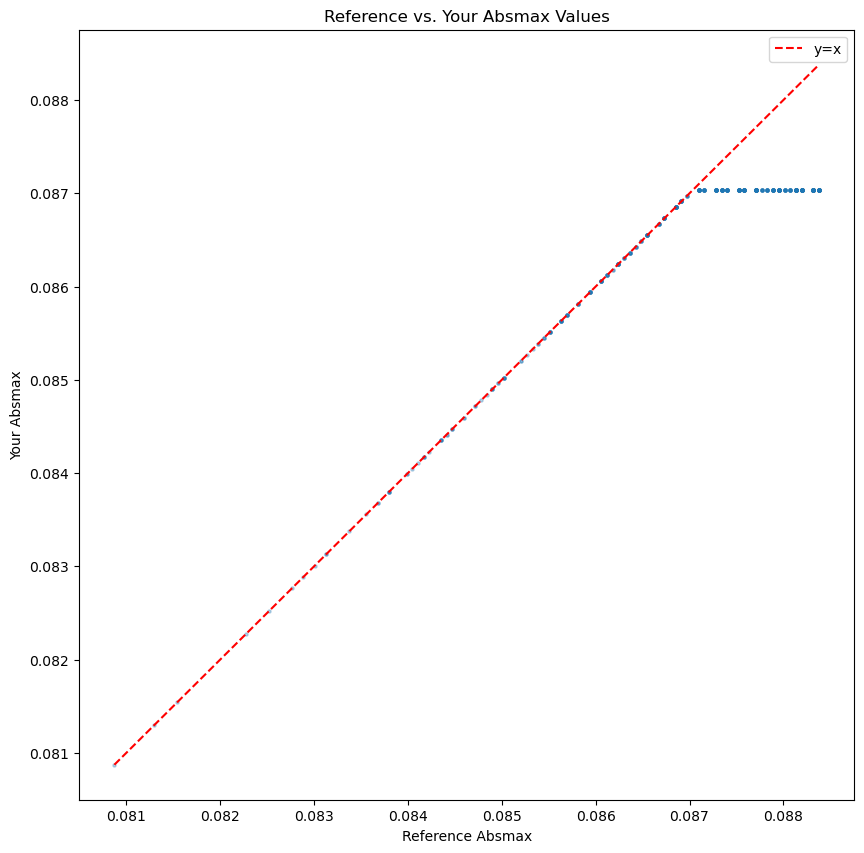

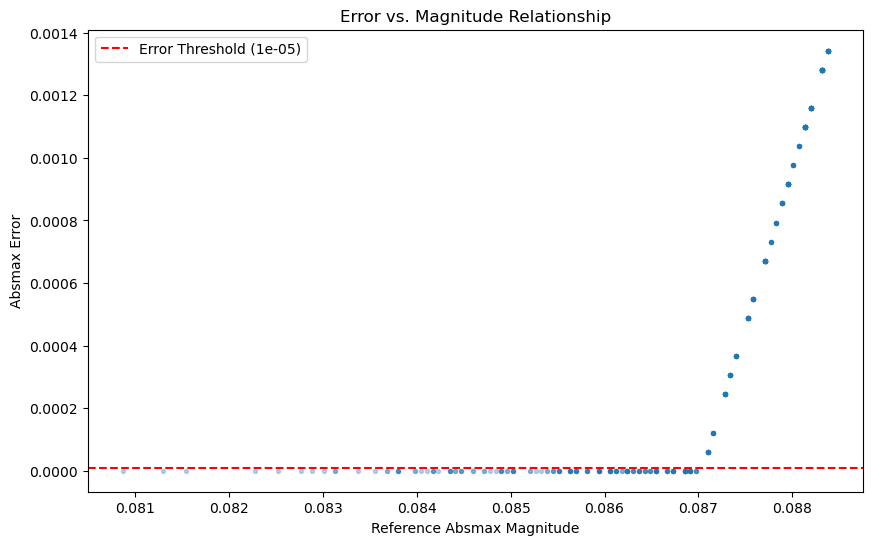

Absmax Error %: 62.500000% | 320/512
  Sample problematic indices:
    Index 0 (block 0):
      Your value: 0.087036
      Expected: 0.087708
      Raw absmax: 192
      Raw code2: 0.121094
      Raw absmax2: 0.005785
      Offset: 0.087023
      Manual Calculation: 0.121094 * 0.005785 + 0.087023 = 0.087723
      Expected code2: 0.118342
    Index 48 (block 0):
      Your value: 0.087036
      Expected: 0.088135
      Raw absmax: 197
      Raw code2: 0.191406
      Raw absmax2: 0.005785
      Offset: 0.087023
      Manual Calculation: 0.191406 * 0.005785 + 0.087023 = 0.088130
      Expected code2: 0.192194
    Index 92 (block 0):
      Your value: 0.087036
      Expected: 0.088318
      Raw absmax: 199
      Raw code2: 0.219531
      Raw absmax2: 0.005785
      Offset: 0.087023
      Manual Calculation: 0.219531 * 0.005785 + 0.087023 = 0.088293
      Expected code2: 0.223846
    Index 144 (block 0):
      Your value: 0.087036
      Expected: 0.087097
      Raw absmax: 160
      Raw cod

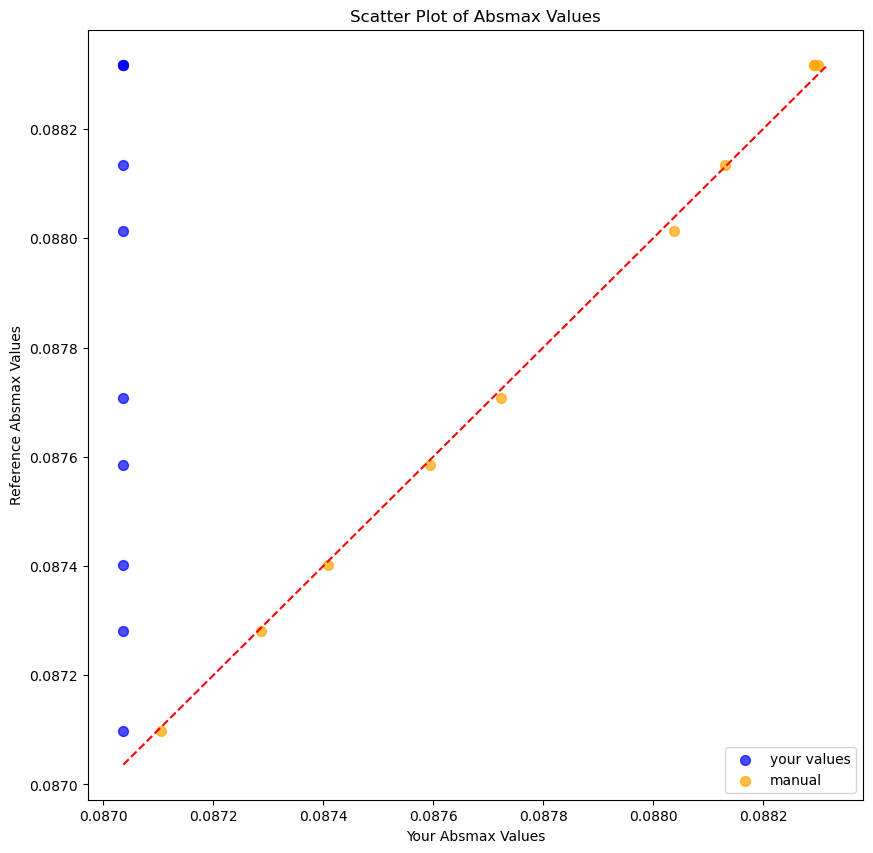

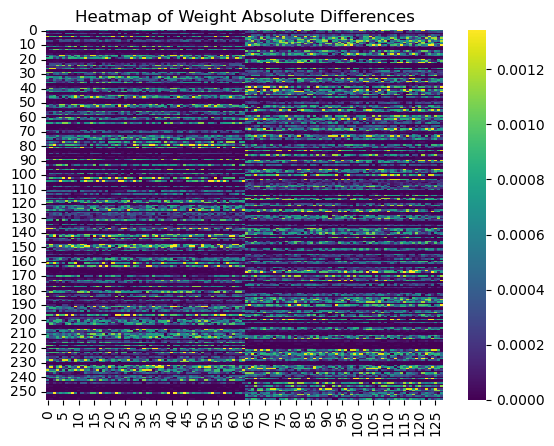

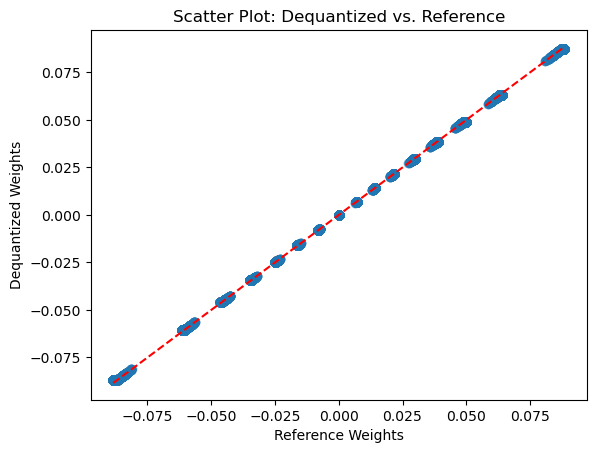


🔴 ISSUE DETECTED: Weight Dequantization
  Max weight difference: 0.001343
  Mismatch %: 65.414429%
  Found 21435 problematic indices
  Sample problematic indices:
    Index 0 (byte 0, first value, block 0):
      Your value: 0.087036
      Reference: 0.087708
      Difference: 0.000671
      Raw quant byte: 0xfc (252)
      Extracted nf4: 15 (lower 4 bits)
      Code mapping: 1.000000
      Your code mapping: 1.000000
      Block absmax: 0.087708
      Your absmax: 0.087036
      Expected calculation: 1.0 * 0.08770751953125 = 0.087708
    Index 3889 (byte 1944, second value, block 60):
      Your value: -0.045685
      Reference: -0.045959
      Difference: 0.000275
      Raw quant byte: 0xc2 (194)
      Extracted nf4: 2 (upper 4 bits)
      Code mapping: -0.524902
      Your code mapping: -0.524902
      Block absmax: 0.087524
      Your absmax: 0.087036
      Expected calculation: -0.52490234375 * 0.0875244140625 = -0.045942
    Index 7645 (byte 3822, second value, block 119):
     

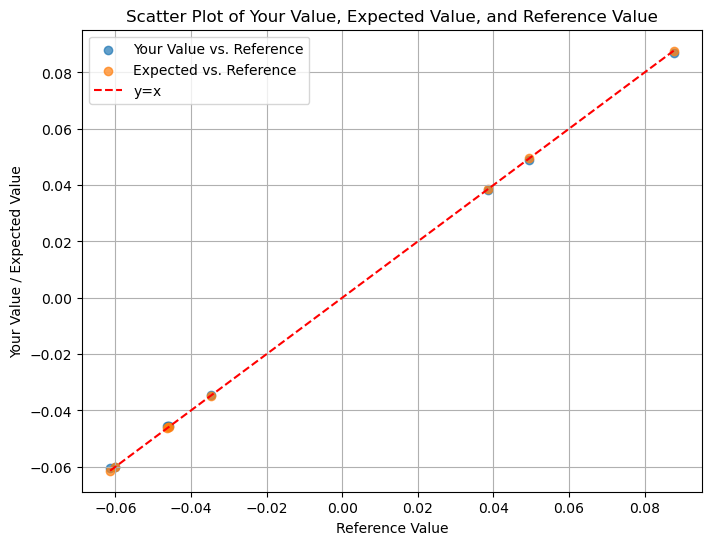

    Problematic blocks: 493 out of 512
    First values with issues: 10711 (50.0%)
    Second values with issues: 10724 (50.0%)
Block size is 64| block absmax: yours 0.087036 | ref 0.087952
Number of unique values in your implementation: 15
Number of unique values in reference implementation: 15


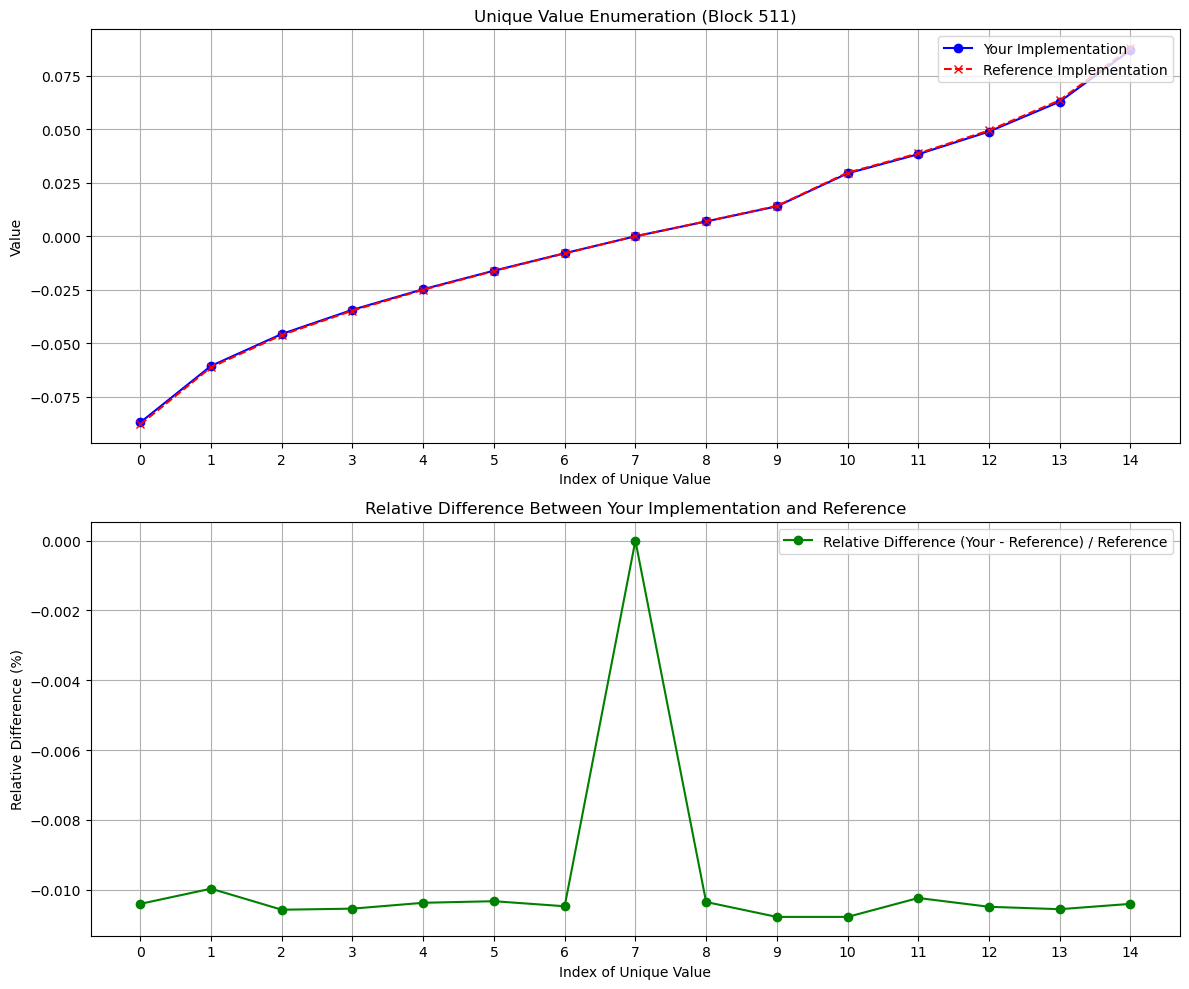

tensor([[ 0.0877,  0.0387,  0.0493,  ..., -0.0464, -0.0349,  0.0299],
        [ 0.0598,  0.0133, -0.0576,  ...,  0.0632, -0.0874, -0.0609],
        [-0.0610, -0.0249, -0.0346,  ..., -0.0599, -0.0159,  0.0291],
        ...,
        [-0.0601,  0.0486, -0.0453,  ..., -0.0611,  0.0878, -0.0347],
        [ 0.0485,  0.0485,  0.0000,  ..., -0.0453, -0.0160, -0.0341],
        [ 0.0000,  0.0610, -0.0587,  ..., -0.0347, -0.0612, -0.0347]],
       device='cuda:0')
tensor([[ 0.0870,  0.0384,  0.0490,  ..., -0.0457, -0.0344,  0.0294],
        [ 0.0598,  0.0133, -0.0576,  ...,  0.0629, -0.0870, -0.0606],
        [-0.0606, -0.0247, -0.0344,  ..., -0.0599, -0.0159,  0.0291],
        ...,
        [-0.0601,  0.0486, -0.0453,  ..., -0.0606,  0.0870, -0.0344],
        [ 0.0485,  0.0485,  0.0000,  ..., -0.0453, -0.0160, -0.0341],
        [ 0.0000,  0.0610, -0.0587,  ..., -0.0344, -0.0606, -0.0344]],
       device='cuda:0')


In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import triton
import triton.language as tl
import torch


# Diagnostic function to compare intermediate results
def diagnostic_dequantize(weight):
    """
    Diagnostic function to compare intermediate results between your implementation
    and the reference implementation.
    """

    if weight.weight.quant_state is None:
        print("No quant_state found, skipping diagnostic.")
        return None

    # Extract components from quant_state
    quant_state = weight.weight.quant_state
    absmax = quant_state.absmax
    shape = quant_state.shape
    dtype = quant_state.dtype
    blocksize = quant_state.blocksize
    offset = quant_state.offset
    state2 = quant_state.state2
    absmax2 = state2.absmax
    code = quant_state.code
    code2 = state2.code
    blocksize2 = state2.blocksize

    print(
        f"Matrix shape: {shape}, blocksize: {blocksize}, blocksize2: {blocksize2}, code2: {code2.shape}, dtype: {dtype}"
    )

    # Get reference dequantized weights
    ref_out = fast_dequantize(weight.weight, quant_state)

    # Step 1: Check absmax dequantization

    n_elements_absmax = absmax.numel()
    ref_out_absmax = torch.empty(
        n_elements_absmax, dtype=dtype, device="cpu"
    )

    ref_flat = ref_out.flatten().to(torch.float16).cpu()

    for i in range(n_elements_absmax):
        block = ref_flat[i * blocksize: (i + 1) * blocksize]
        block_absmax = abs(block).max()
        ref_out_absmax[i] = block_absmax


    # Step 2: Check weight dequantization
    your_out = torch.empty(shape, dtype=dtype, device=weight.weight.device)
    your_absmax = torch.empty(
        n_elements_absmax, dtype=dtype, device=weight.weight.device
    )
    your_debug1 = torch.empty_like(weight.weight.data, dtype=torch.float16)
    your_debug2 = torch.empty_like(weight.weight.data, dtype=torch.float16)
    weight_grid = (triton.cdiv(weight.weight.numel(), 1024),)
    _your_dequantize_nf4_kernel[weight_grid](
        weight_ptr=weight.weight.data,
        absmax_ptr=absmax,
        absmax2_ptr=absmax2,
        code_ptr=code,
        code2_ptr=code2,
        offset_ptr=offset,
        out_ptr=your_out,
        weight_blocksize=blocksize,
        absmax_blocksize=blocksize2,
        total_elements=your_out.numel(),
        BLOCK_SIZE=1024,
        debug_absmax_ptr=your_absmax,
        debug_quant1_ptr=your_debug1,
        debug_quant2_ptr=your_debug2
    )

    # Compare absmax values
    absmax_diff = (your_absmax - ref_out_absmax.cuda()).abs()
    max_absmax_diff = absmax_diff.max().item()
    rel_absmax_diff = absmax_diff / ref_out_absmax.cuda()
    error_threshold = 1e-5

    if max_absmax_diff > 1e-5:
        print("\n🔴 ISSUE DETECTED: Absmax Dequantization")
        print(f"  Max absmax difference: {max_absmax_diff:.6f}")

        print(absmax2)

        ref_out_absmax = ref_out_absmax.to(torch.float16).cpu().numpy()
        your_absmax = your_absmax.to(torch.float16).cpu().numpy()

        plt.figure(figsize=(10, 10))
        plt.scatter(ref_out_absmax, your_absmax, alpha=0.3, s=5)
        plt.xlabel("Reference Absmax")
        plt.ylabel("Your Absmax")
        plt.title("Reference vs. Your Absmax Values")
        # Add y=x line for reference
        max_val = max(ref_out_absmax.max().item(), your_absmax.max().item())
        min_val = min(ref_out_absmax.min().item(), your_absmax.min().item())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x')
        plt.legend()
        plt.show()

        # Visualization: Plot relationship between error and magnitude
        plt.figure(figsize=(10, 6))
        plt.scatter(ref_out_absmax, absmax_diff.to(torch.float16).cpu().numpy(), alpha=0.3, s=8)
        plt.xlabel("Reference Absmax Magnitude")
        plt.ylabel("Absmax Error")
        plt.title("Error vs. Magnitude Relationship")
        plt.axhline(error_threshold, color='r', linestyle='--', label=f'Error Threshold ({error_threshold})')
        plt.legend()
        plt.show()
    

        # Find problematic indices
        manual_calculations=[]
        your_absmax_values = []
        ref_absmax_values = []

        problem_indices = torch.where(absmax_diff > error_threshold)[0]
        if len(problem_indices) > 0:
            print(f"Absmax Error %: {len(problem_indices)/absmax_diff.shape[0]:%} | {len(problem_indices)}/{absmax_diff.shape[0]}")
            print("  Sample problematic indices:")
            for idx in problem_indices[::32][:20]:
                i = idx.item() # i is the weight block number for the absmax
                block_idx = i // blocksize2
                manual_calculation = code2[int(absmax[i].item())] * absmax2[block_idx].item() + offset
                print(f"    Index {i} (block {block_idx}):")
                print(f"      Your value: {your_absmax[i].item():.6f}")
                print(f"      Expected: {ref_out_absmax[i].item():.6f}")
                print(f"      Raw absmax: {int(absmax[i].item())}")
                print(f"      Raw code2: {code2[int(absmax[i].item())]:.6f}")
                print(f"      Raw absmax2: {absmax2[block_idx].item():.6f}")
                print(f"      Offset: {offset:.6f}")
                print(
                    f"      Manual Calculation: {code2[int(absmax[i].item())]:.6f} * {absmax2[block_idx].item():.6f} + {offset:.6f} = {manual_calculation:.6f}"
                )
                print(f"      Expected code2: {(ref_out_absmax[i].item() - offset) / absmax2[block_idx].item():.6f}")
                manual_calculations.append(manual_calculation.item())
                your_absmax_values.append(your_absmax[i].item())
                ref_absmax_values.append(ref_out_absmax[i].item())

            # plot scatter 
            plt.figure(figsize=(10, 10))
            plt.scatter(your_absmax_values, ref_absmax_values, alpha=0.7, s=50, c="blue", label="your values")
            plt.scatter(manual_calculations, ref_absmax_values, alpha=0.7, s=50, c="orange", label="manual")
            plt.xlabel('Your Absmax Values')
            plt.ylabel('Reference Absmax Values')
            plt.legend()
            plt.title('Scatter Plot of Absmax Values')

            # Add a y=x reference line
            min_val = min(min(your_absmax_values), min(ref_absmax_values))
            max_val = max(max(your_absmax_values), max(ref_absmax_values))
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x')
            plt.show()
    else:
        print("✅ Absmax dequantization looks correct")


    # Handle potential transposition
    is_transposed = weight.weight.shape[0] == 1
    your_out = your_out.t() if is_transposed else your_out

    # Compare weights
    weight_diff = (your_out - ref_out).abs()
    max_weight_diff = weight_diff.max().item()

    sns.heatmap(weight_diff.to(torch.float16).cpu().numpy(), cmap="viridis")
    plt.title("Heatmap of Weight Absolute Differences")
    plt.show()

    yours_flat = your_out.flatten().to(torch.float16).cpu().numpy()
    ref_flat = ref_out.flatten().to(torch.float16).cpu().numpy()
    weight_diff_flat = weight_diff.flatten().to(torch.float16).cpu().numpy()
    plt.scatter(ref_flat, yours_flat, alpha=0.3)
    plt.xlabel("Reference Weights")
    plt.ylabel("Dequantized Weights")
    plt.title("Scatter Plot: Dequantized vs. Reference")
    plt.plot([min(ref_flat), max(ref_flat)], [min(ref_flat), max(ref_flat)], "r--")
    plt.show()

    if max_weight_diff > 1e-5:
        print("\n🔴 ISSUE DETECTED: Weight Dequantization")
        print(f"  Max weight difference: {max_weight_diff:.6f}")

        debug1_flat = your_debug1.flatten().to(torch.float16).cpu().numpy()
        debug2_flat = your_debug2.flatten().to(torch.float16).cpu().numpy()

        # Find problematic indices
        problem_indices = np.where(weight_diff_flat > 1e-5)[0]

        print(f"  Mismatch %: {problem_indices.shape[0] / weight_diff_flat.shape[0]:%}")
        if len(problem_indices) > 0:
            print(f"  Found {len(problem_indices)} problematic indices")
            print("  Sample problematic indices:")

            your_values = []
            ref_values = []
            expected_values = []

            for idx in problem_indices[::(len(problem_indices) // 8)]:
                i = idx.item()
                # Calculate which byte this value came from
                byte_idx = i // 2
                # Calculate if this is the first or second value in the byte
                is_second = i % 2 == 1
                # Calculate which block this value belongs to
                block_idx = byte_idx // (blocksize // 2)

                # Get the original quantized byte
                quant_byte = weight.weight[byte_idx].item()

                # Extract the 4-bit values
                quant_1 = (quant_byte >> 4) & 0x0F  # Upper 4 bits (second element)
                quant_2 = quant_byte & 0x0F  # Lower 4 bits (first element)

                # Get the code value
                code_value = quant_2 if is_second else quant_1

                block_absmax = ref_out_absmax[block_idx]

                # Get the code mapping
                code_mapping = quant_state.code[code_value].item()

                # Calculate expected dequantized value
                expected_value = code_mapping * block_absmax

                debug_value = debug2_flat if is_second else debug1_flat

                print(
                    f"    Index {i} (byte {byte_idx}, {'second' if is_second else 'first'} value, block {block_idx}):"
                )
                print(f"      Your value: {yours_flat[i].item():.6f}")
                print(f"      Reference: {ref_flat[i].item():.6f}")
                print(f"      Difference: {weight_diff_flat[i].item():.6f}")
                print(f"      Raw quant byte: 0x{quant_byte:02x} ({quant_byte})")
                print(
                    f"      Extracted nf4: {code_value} ({'upper 4 bits' if is_second else 'lower 4 bits'})"
                )
                print(f"      Code mapping: {code_mapping:.6f}")
                print(f"      Your code mapping: {debug_value[byte_idx].item():.6f}")
                print(f"      Block absmax: {block_absmax:.6f}")
                print(f"      Your absmax: {your_absmax[block_idx].item():.6f}")
                print(
                    f"      Expected calculation: {code_mapping} * {block_absmax} = {expected_value:.6f}"
                )

                your_values.append(yours_flat[i].item())
                ref_values.append(ref_flat[i].item())
                expected_values.append(expected_value)

            plt.figure(figsize=(8, 6))
            plt.scatter(
                ref_values, your_values, label="Your Value vs. Reference", alpha=0.7
            )
            plt.scatter(
                ref_values, expected_values, label="Expected vs. Reference", alpha=0.7
            )

            # Add labels and title
            plt.xlabel("Reference Value")
            plt.ylabel("Your Value / Expected Value")
            plt.title("Scatter Plot of Your Value, Expected Value, and Reference Value")

            # Add legend
            plt.legend()

            # Add a diagonal line for reference (where your value equals the reference)
            min_val = min(min(ref_values), min(your_values), min(expected_values))
            max_val = max(max(ref_values), max(your_values), max(expected_values))
            plt.plot(
                [min_val, max_val],
                [min_val, max_val],
                color="red",
                linestyle="--",
                label="y=x",
            )  # Diagonal line
            plt.legend()


            # Show the plot
            plt.grid(True)
            plt.show()

            # Check if there's a pattern in which blocks have issues
            problem_blocks = torch.unique(
                torch.tensor(
                    [i.item() // 2 // (blocksize // 2) for i in problem_indices]
                )
            )
            print(f"    Problematic blocks: {len(problem_blocks)} out of {len(absmax)}")
            if len(problem_blocks) < 10:
                print(f"    Block indices: {problem_blocks.tolist()}")

            # Check if there's a pattern in first vs second value in byte
            second_values = sum(1 for i in problem_indices if i.item() % 2 == 1)
            first_values = len(problem_indices) - second_values
            print(
                f"    First values with issues: {first_values} ({first_values/len(problem_indices)*100:.1f}%)"
            )
            print(
                f"    Second values with issues: {second_values} ({second_values/len(problem_indices)*100:.1f}%)"
            )

    # Extract the block values for first/last block
    your_block = yours_flat[-1:-blocksize - 1 :-1]
    ref_block = ref_flat[-1:-blocksize - 1:-1]

    def derive_encoding(values, tolerance=1e-8):
        unique_values = []
        value_to_code = {}

        for i, val in enumerate(values):
            # Check if this value is close to any existing unique value
            found_match = False
            for j, unique_val in enumerate(unique_values):
                if abs(val - unique_val) < tolerance:
                    value_to_code[i] = j
                    found_match = True
                    break

            # If no match found, add as a new unique value
            if not found_match:
                value_to_code[i] = len(unique_values)
                unique_values.append(val)

        return value_to_code, unique_values

    # Derive encodings for both implementations
    your_encoding, your_unique = derive_encoding(your_block)
    ref_encoding, ref_unique = derive_encoding(ref_block)

    # print(f"manual abs max: {manual_absmax[0]}, {your_abs_max[0]}")
    print(
        f"Block size is {blocksize}| block absmax: yours {max(your_block, key=abs):.6f} | ref {max(ref_block, key=abs):.6f}"
    )
    print(f"Number of unique values in your implementation: {len(your_unique)}")
    print(f"Number of unique values in reference implementation: {len(ref_unique)}")

    # For NF4, we expect 16 unique values
    if len(your_unique) > 16:
        print(
            f"⚠️ Warning: Expected 16 unique values for NF4, but found {len(your_unique)}"
        )

    if len(ref_unique) > 16:
        print(
            f"⚠️ Warning: Reference implementation has {len(ref_unique)} unique values (expected 16)"
        )

    def plot_encoding():
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Plot your unique values
        your_indices = range(len(your_unique))
        ax1.plot(
            your_indices,
            sorted(your_unique),
            marker="o",
            linestyle="-",
            label="Your Implementation",
            color="blue",
        )

        # Plot reference unique values
        ref_indices = range(len(ref_unique))
        ax1.plot(
            ref_indices,
            sorted(ref_unique),
            marker="x",
            linestyle="--",
            label="Reference Implementation",
            color="red",
        )

        ax1.set_xlabel("Index of Unique Value")
        ax1.set_ylabel("Value")
        ax1.set_title(f"Unique Value Enumeration (Block {block_idx})")
        ax1.set_xticks(list(range(max(len(your_unique), len(ref_unique)))))
        ax1.set_xticklabels(
            [str(i) for i in range(max(len(your_unique), len(ref_unique)))]
        )
        ax1.legend(loc="upper right")
        ax1.grid(True)

        min_len = min(len(your_unique), len(ref_unique))
        your_values = sorted(your_unique)[:min_len]
        ref_values = sorted(ref_unique)[:min_len]

        # Calculate relative difference (Your - Reference) / Reference
        relative_difference = [
            (your - ref) / ref if ref != 0 else 0  # Avoid division by zero
            for your, ref in zip(your_values, ref_values)
        ]

        relative_indices = range(min_len)
        ax2.plot(
            relative_indices,
            relative_difference,
            marker="o",
            linestyle="-",
            color="green",
            label="Relative Difference (Your - Reference) / Reference",
        )

        ax2.set_xlabel("Index of Unique Value")
        ax2.set_ylabel("Relative Difference (%)")
        ax2.set_title("Relative Difference Between Your Implementation and Reference")
        ax2.set_xticks(list(range(min_len)))
        ax2.set_xticklabels([str(i) for i in range(min_len)])
        ax2.legend(loc="upper right")
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    plot_encoding()

    code_comparison = []
    code_mismatches = {}
    for index, (curr, ref) in enumerate(zip(your_block, ref_block)):
        # get encodings
        curr_code = [
            code for value, code in your_encoding.items() if abs(value - curr) < 1e-5
        ]
        ref_code = [
            code for value, code in ref_encoding.items() if abs(value - curr) < 1e-5
        ]

        if curr_code != ref_code:
            code_mismatches[index] = [curr_code, ref_code]
            if len(code_mismatches) == 1:
                print(
                    f"Mismatch found at index {index} where {curr} mapped to {curr_code} but {ref} mapped to {ref_code}"
                )
        code_comparison.append("✅" if curr_code == ref_code else "🔴")

    if len(code_mismatches) > 0:
        print(code_comparison)

    print(ref_out)
    print(your_out)


def run_diagnostic(hd=4096, m=14336, dtype=torch.bfloat16, seed=3408):
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        print(f"Creating model with hd={hd}, m={m}, dtype={dtype}")
        # Create a model with the specified parameters
        mlp = MLP(hd=hd, m=m, dtype=dtype).to("cuda")

        # Run the diagnostic on each weight matrix
        print("\n=== DIAGNOSTIC FOR UP_PROJ ===")
        up_results = diagnostic_dequantize(mlp.up_proj)

        # print("\n=== DIAGNOSTIC FOR GATE_PROJ ===")
        # gate_results = diagnostic_dequantize(mlp.gate_proj)

        # print("\n=== DIAGNOSTIC FOR DOWN_PROJ ===")
        # down_results = diagnostic_dequantize(mlp.down_proj)

        # return {
        #     'up_proj': up_results,
        #     'gate_proj': gate_results,
        #     'down_proj': down_results
        # }

    except Exception as e:
        print(f"Error in run_diagnostic: {e}")
        import traceback

        traceback.print_exc()
        return None


def run_all_diagnostics(hd=24, m=96, dtype=torch.bfloat16, seed=3409):
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        # Run focused diagnostic
        results = run_diagnostic(hd, m, dtype, seed)

        # check_code_mapping_consistency(mlp.up_proj, block_idx=0)

    except:
        pass


print("\n=== RUNNING DIAGNOSTIC ON SMALL MODEL ===")
# small_results = run_all_diagnostics(hd=256, m=256, dtype=torch.bfloat16, seed=3409)
run_all_diagnostics(hd=128, m=256, dtype=torch.bfloat16, seed=3409)

In [ ]:
### TEST IT BELOW:
test_dequantize(your_dequantize_nf4)

### CALCULATE SPEEDUP (hopefully 1.15x faster or more)
test_dequantize(unsloth_dequantize) / test_dequantize(your_dequantize_nf4)

## Marking Criteria for A) Max points = 14
```python
if attemped_A:
    A_score = 0
    if single_triton_kernel: A_score += 3
    speedup = old_time / new_time
    if speedup <= 1.00: A_score -= 3
    if speedup >= 1.05: A_score += 1
    if speedup >= 1.10: A_score += 2
    if speedup >= 1.15: A_score += 2
    if kernel_works_in_torch_compile: A_score += 1
    else: A_score -= 1
    if custom_asm_works: A_score += 3
    if uses_cache_eviction: A_score += 1
    if tested_in_f16_and_bf16: A_score += 1
    else: A_score -= 1
    final_score += A_score
else:
    final_score += 0
```

---
---
---
<a name="FSDP2"></a>
## B) Make `QLoRA` work with `FSDP2` [Difficulty: Medium to Hard] [Max points: 10]

1. Goal: Write a single Python script to finetune Llama 3.1 8B on 2x or more GPUs with FSDP2.

2. You must showcase this working in a free **Kaggle notebook with 2 x Tesla T4 GPUs**.

3. Pipeline parallelism is also fine, but must utilize [`zero bubble scheduling`](https://pytorch.org/docs/stable/distributed.pipelining.html#torch.distributed.pipelining.schedules.ScheduleInterleavedZeroBubble) somehow.

4. Can use a pre-quantized 4bit BnB safetensor file from [Unsloth's HF page](https://huggingface.co/unsloth) or a full 16bit one, but must do QLoRA.

5. Can use `accelerate` but must be FSDP2 or related - you can investigate https://github.com/huggingface/accelerate/pull/3394, Torch Titan, other repos etc.

6. Must be fully `transformers` compatible - so we must use `TrainingArguments` and `Trainer`, or `TRL` related classes.

7. The loss must be equivalent to single GPU training.

8. You must enable all features in FSDP2 - ie showcase offloading, checkpointing, mixed precision training etc.

9. You can use `nf4` from `torch AO`, but best from `bitsandbytes`.

10. Finally showcase everything working in a free Kaggle 2x Tesla T4 notebook.

In [ ]:
# HELPFUL functions to undo Unsloth patches:
import sys


def remove_patched_module(package_name):
    modules_to_delete = [
        name
        for name in sys.modules
        if name == package_name or name.startswith(package_name + ".")
    ]
    for name in modules_to_delete:
        del sys.modules[name]


remove_patched_module("trl")
remove_patched_module("transformers")
remove_patched_module("peft")
remove_patched_module("bitsandbytes")

Below is an example script which should run fine in Kaggle 2x Telsa T4s:

In [ ]:
import os

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = (
    "expandable_segments:True," "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"
)

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType

max_seq_length = 2048
torch.set_default_dtype(torch.float16)
model_name = "unsloth/meta-Llama-3.1-8B-Instruct-bnb-4bit"
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    attn_implementation="sdpa",
    quantization_config=bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

lora_config = LoraConfig(
    r=64,
    lora_alpha=128,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_dropout=0,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name:
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Get dataset
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig

url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files={"train": url}, split="train[:10%]")

Reminder your code must have the same loss curve over 60 steps or so.

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    processing_class=tokenizer,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=1,
        max_steps=10,
        logging_steps=1,
        output_dir="outputs",
        seed=3407,
        max_seq_length=max_seq_length,
        fp16=model.get_input_embeddings().weight.dtype == torch.float16,
        bf16=model.get_input_embeddings().weight.dtype == torch.bfloat16,
        report_to="none",  # For W&B
        dataset_num_proc=4,
    ),
)
trainer.train()

In [ ]:
del model
import gc

gc.collect()
torch.cuda.empty_cache()

## Marking Criteria for B) Max points = 10
```python
if attemped_B:
    B_score = 0
    if FSDP2_works_with_QLoRA:
        if torch_compile_works: B_score += 5
        else: B_score += 3
        if uses_part_A_and_single_kernel_and_faster: B_score += 3
        elif uses_torchAO:
            if torchAO_slower_than_BnB: B_score -= 3
    elif TP_or_PP_with_QLoRA:
        if zero_bubble: B_score += 3
        else: B_score += 2
    elif FSDP1_works_with_QLoRA:
        B_score += 1
    if kaggle_notebook_2_tesla_t4_example:
        B_score += 2
    else:
        B_score = 0
    final_score += B_score
else:
    final_score -= 2
```

---
---
---
<a name="COMPILE"></a>
## C) Make `torch.compile` work without graph breaks for QLoRA [Difficulty: Easy to Medium] [Max points: 9]

1. Goal: Write a single Python script like task B), except the goal is to `torch.compile` all modules if possible.

2. There must NOT be graph breaks, and excessive re-compilations should not be seen.

3. You should have say max 30 compilations. Over 60 is definitely wrong.

4. The loss must match with the non compiled module.

5. Utilize patching as much as possible.

6. Think about which areas might need disabling for compilation. Think about regional compilation. How do we compile sections efficiently?

7. Log memory / VRAM usage, and monitor speedups as well.

8. Must work for QLoRA.

We provided a script below, and showcased how to detect if graph breaks are seen. We also torch compiled the MLP for Llama:

In [ ]:
import torch

torch_compile_options = torch_compile_options = {
    "epilogue_fusion": True,
    "max_autotune": True,
    "shape_padding": True,
    "trace.enabled": True,
    "triton.cudagraphs": False,
}


@torch.compile(fullgraph=False, dynamic=True, options=torch_compile_options)
def compiled_llama_mlp(self, x):
    down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
    return down_proj


import transformers.models.llama.modeling_llama

transformers.models.llama.modeling_llama.LlamaMLP.forward = compiled_llama_mlp

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = (
    "expandable_segments:True," "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"
)

max_seq_length = 1024
torch.set_default_dtype(torch.float16)
model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    attn_implementation="sdpa",
    quantization_config=bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_dropout=0,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name:
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)

# Currently GC will cause torch.compile to be disabled, so disable it
# model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Get dataset
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig

url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files={"train": url}, split="train[:10%]")

We provide full logging for `torch.compile` like below:

In [ ]:
# Must show all graph breaks are not seen with torch.compile
import os

os.environ["TORCHDYNAMO_VERBOSE"] = "1"
os.environ["TORCHINDUCTOR_FORCE_DISABLE_CACHES"] = "1"
os.environ["TORCHINDUCTOR_COMPILE_THREADS"] = "1"

import logging

torch._inductor.config.debug = True
torch._logging.set_logs(
    dynamo=logging.WARN,
    inductor=logging.WARN,
    graph_breaks=True,
    recompiles=True,
    recompiles_verbose=True,
    compiled_autograd_verbose=True,
    # aot_joint_graph = True, # Enable for more logs
    # aot_graphs = True,
)
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = False

When we execute the code below, we can see graph breaks - remove them.

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    processing_class=tokenizer,
    args=SFTConfig(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=2,
        warmup_steps=1,
        max_steps=10,
        logging_steps=1,
        output_dir="outputs",
        seed=3407,
        max_seq_length=max_seq_length,
        fp16=model.get_input_embeddings().weight.dtype == torch.float16,
        bf16=model.get_input_embeddings().weight.dtype == torch.bfloat16,
        report_to="none",  # For W&B
        dataset_num_proc=4,
    ),
)
trainer.train()

Log all your steps for debugging in a Colab (maybe this one). Edward's blog http://blog.ezyang.com/, Horace's blogs https://www.thonking.ai/, Slaying OOMs by Jane & Mark: ttps://www.youtube.com/watch?v=UvRl4ansfCg could be useful.

## Marking Criteria for C) Max points = 9
```python
if attemped_C:
    C_score = 0
    if uses_flex_attention:
        if dynamic_sequence_length_works: C_score += 3
        else: C_score += 1
    if no_torch_compile_BnB: C_score -= 2
    elif use_part_A: C_score += 1
    elif torch_compile_BnB: C_score += 1

    if attention_compiled:
        if excessive_recompilation: C_score -= 3
        else: C_score += 2
    if mlp_compiled:
        if excessive_recompilation: C_score -= 3
        C_score += 1

    if not loss_compiled: C_score -= 1
    if not layernorms_compiled: C_score -= 3

    if max_autotune_triton_matmul:
        if excessive_recompilation: C_score -= 2
        else: C_score += 2
    
    final_score += C_score
else:
    final_score -= 1
```

---
---
---
<a name="ISSUES"></a>
## D) Help solve 🦥 Unsloth issues! [Difficulty: Varies] [Max points: 12]

Head over to https://github.com/unslothai/unsloth, and find some issues which are still left standing / not resolved. The tag **currently fixing** might be useful. It's best to attempt these features:

* **<ins>VLMs Data Collator</ins>** [Points = 1] Make text & image mixing work efficiently -so some inputs can be text only. Must work on Qwen, Llama, Pixtral.

* **<ins>VLMs image resizing</ins>** [Points = 1] Allow finetuner to specify maximum image size, or get it from the config.json file. Resize all images to specific size to reduce VRAM.

* **<ins>GGUF Vision support</ins>** [Points = 1] Allow exporting vision finetunes to GGUF directly. Llava and Qwen VL must work.

* **<ins>Support Flex Attention</ins>** [Points = 2] Allow dynamic sequence lengths without excessive recompilation. Make this work on SWAs and normal causal masks. Also packed sequence masks

* **<ins>Support Sequence Classification</ins>** [Points = 1] Create patching functions to patch over AutoModelForSequenceClassification, and allow finetuner to use AutoModelForSequenceClassification

* **<ins>Refactor Attention</ins>** [Points = 2] Refactor and merge xformers, SDPA, flash-attn, flex-attention into a simpler interface. Must work seamlessly inside of Unsloth.

* **<ins>Tool Calling</ins>** [Points = 1] Provide a tool calling Colab notebook and make it work inside of Unsloth

* **<ins>VLMs train only on completions</ins>** [Points = 1] Edit `train_on_responses_only` to allow it to work on VLMs.

* **<ins>Windows support</ins>** [Points = 2] Allow `pip install unsloth` to work in Windows - Triton, Xformers, bitsandbytes should all function. You might need to edit `pyproject.toml`

## Marking Criteria for D) Max points = 12
```python
if attemped_D:
    D_score = 0
    for subtask in subtasks:
        if sucessfully_completed_subtask:
            D_score += score_for_subtask
    final_score += D_score
else:
    final_score -= 2
```

---
---
---
<a name="MATH"></a>
## E) Memory Efficient Backprop [Difficulty: Medium to Hard] [Max points: 10]

In LLMs, the last layer is a projection matrix to calculate the probabilities of the next token, ie $\sigma(XW)$. However, if the vocabulary size is very large, say 128K, then the materialization of the logits causes VRAM spikes.

For example, if the `bsz = 4, qlen = 4096, hd = 4096, vocab = 128K`, then the memory usage for the logits in bfloat16 would be 4GB. In the worst case, we might even need to upcast logits to float32, so 8GB is needed.

In Unsloth, we utilize [Apple's Cut Cross Entropy Loss](https://machinelearning.apple.com/research/cut-your-losses) to reduce VRAM usage, by allowing a Triton kernel to create the logits on the fly to calculate the cross entropy loss. But this does not generalize well to other functions.

Our goal is to generalize this ultimately, but directly creating logits on the fly will be hard. Instead, let's take a slightly less complex approach. Let's first review some stuff. We first notice that during the normal case after forming the intermediate logits for 2 batches, we then do a gather function to aggregate the intermediate results into a single column:
$$
\begin{align}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \times W &= \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \\
f \bigg( \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \bigg) &= \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}
\end{align}
$$

So, if we can somehow skip the materialization of the intermediate logits, and just output the output of `f`, we can save a lot of VRAM!

Notice during backpropagation we can use the chain rule:
$$
\begin{align}
\frac{dL}{dX} &= \frac{dL}{dy} \frac{dy}{dX} ; \frac{dL}{dW} = \frac{dL}{dy} \frac{dy}{dW} \\
\frac{dL}{dy} &= \text{Downstream from backprop} \\
\frac{dy}{dX} &= W^T \\
\frac{dy}{dW} &= X^T \\
\frac{dL}{dX} &= \frac{dL}{dy} W^T \\
\frac{dL}{dW} &= X^T \frac{dL}{dy} \\
\end{align}
$$

If we simply compute the intermediate tensors on the fly via batches, say we do batch 1, then batch 2, we can reduce VRAM usage from 4GB to 2GB!

$$
\begin{align}
\frac{dL}{dX} &= \begin{bmatrix} \frac{dL_1}{dy_1} W^T \\ \frac{dL_2}{dy_2} W^T \end{bmatrix} \\
\frac{dL}{dW} &= \bigg( X_1^T \frac{dL_1}{dy_1} + X_2^T  \frac{dL_2}{dy_2} \bigg)
\end{align}
$$

1. Your goal is to write a `torch.autograd.Function` with a `forward` and `backward` pass showcasing this memory efficient implementation.

2. You must NOT hard code the derivatives - move the transformation function from the logits / intermeditate tensors to a smaller tensor as a separate function which can allow `autograd` to pass through it.

3. As a hint, look at `torch.checkpoint` at https://github.com/pytorch/pytorch/blob/main/torch/utils/checkpoint.py. Also, don't forget about the upstream gradients! We need to multiply them to the current gradients!

4. Make the Cross Entropy Loss work. You must show other functions working as well.

In [ ]:
def transformation_function(batch, linear, labels):
    x = linear(batch).float()  # Up projection to large space
    from torch.nn import CrossEntropyLoss

    down_projection_function = CrossEntropyLoss(reduction="sum")
    # Down projection to small space
    loss = down_projection_function(x.view(-1, x.shape[-1]), labels.view(-1))
    return loss


# class MemoryEfficientLinear(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, X, linear, labels, forward_function):
#         outputs = []
#         # EDIT THIS FUNCTION
#         output = forward_function(X, linear, labels)
#         ctx.save_for_backward(X)
#         return output

#     @staticmethod
#     def backward(ctx, dY):
#         X = ctx.saved_tensors
#         # EDIT THIS FUNCTION
#         return X, None, None, None


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

assert device.type == "cuda", "vram measurements won't work; check environment setup"

In [ ]:
class NaiveLinear(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X, linear, labels, forward_function):
        """
        Naive forward pass that does NOT use chunking.
        This computes the full projection XW at once.

        Args:
          - X: Input tensor (bs x seq_len x hidden) or (seq_len x hidden)
          - linear: Linear projection function
          - labels: Target labels (bs x seq_len) or (seq_len)
          - forward_function: Function computing f(XW)

        Returns:
          - Computed loss (scalar) or transformed tensor
        """

        with torch.no_grad():
            # Compute f(XW), e.g., cross-entropy loss
            loss = forward_function(X, linear, labels)

        # Save context for backward pass
        # ctx.save_for_backward(X, labels)
        ctx.save_for_backward(X, labels)
        ctx.linear = linear
        ctx.forward_function = forward_function

        return loss

    @staticmethod
    def backward(ctx, dY):
        """
        Naive backward pass that computes gradients from the saved full logits.

        Args:
          - dY: Gradient from the next layer (scalar or tensor)

        Returns:
          - Gradients w.r.t. X, None, None, None
        """

        X, labels = ctx.saved_tensors
        linear = ctx.linear
        forward_function = ctx.forward_function

        # Re-enable autograd for X and logits
        with torch.enable_grad():
            X.requires_grad = True
            linear.weight.requires_grad = True

            # Compute f(XW) again with autograd enabled to track gradients
            loss = forward_function(X, linear, labels)

        # Compute gradients with respect to X and W
        loss.backward(dY)

        return X.grad, None, None, None  # Grad w.r.t. X, W, None, None


# Example model and data
batch_size = 4
seq_length = 512  # Large sequence length
hidden_dim = 4096
vocab_size = 32_000

# Model
linear_layer = nn.Linear(hidden_dim, vocab_size, bias=False)

# Verify parameter properties
print("Weight requires_grad:", linear_layer.weight.requires_grad)
print("Weight shape:", linear_layer.weight.shape)

# Inputs (batch, seq, hidden)
X = torch.randn(batch_size, seq_length, hidden_dim, requires_grad=True)
labels = torch.randint(0, vocab_size, (batch_size, seq_length), requires_grad=False)

# Compute loss using memory-efficient linear
loss = NaiveLinear.apply(X, linear_layer, labels, transformation_function)
print(f"Memory-efficient loss: {loss.item()}")

# Compute gradients
loss.backward()
print("Gradients computed successfully.")
print(
    f"Gradient of linear layer: {linear_layer.weight.grad.shape} || {linear_layer.weight.grad.sum()}"
)
print(f"Gradient of X: {X.grad.shape} || {X.grad.sum()}")

In [ ]:
class MemoryEfficientLinear(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X, linear, labels, forward_function):
        """
        Forward pass for memory-efficient linear projection + transformation.

        - X: Input tensor, could be (bs x seq_len x hidden) or (seq_len x hidden)
        - linear: Linear layer (performs projection to large space)
        - labels: Target labels for cross-entropy loss ((bs) x seq_len x vocab)
        - forward_function: Function that computes f(XW)
        - chunk_size: How many rows to process at once

        Returns:
            The total loss computed in chunks
        """
        outputs = []
        # EDIT THIS FUNCTION
        # we want to compute f(XW) without ever triggering a compute of XW
        # hence we do this in parts.

        # chunk X; for now split into only 2
        num_chunks = 2
        seq_dim = len(X.shape) - 2
        seq_len = X.shape[seq_dim]
        num_chunks = min(seq_len, num_chunks)
        chunk_size = (seq_len + num_chunks - 1) // num_chunks

        # we unfortunately also need to be aware of the reduction method.
        # in the case of CE loss above, it's mean
        ctx.reduction = "sum"  # can be None

        # save context for backward step
        ctx.linear = linear
        ctx.forward_function = forward_function
        ctx.num_chunks = num_chunks
        ctx.chunk_size = chunk_size
        ctx.seq_dim = seq_dim
        ctx.seq_len = seq_len
        ctx.save_for_backward
        ctx.save_for_backward(X, labels)  # save chunked version instead!

        with torch.no_grad():
            for i in range(num_chunks):
                start = i * chunk_size
                end = min((i + 1) * chunk_size, seq_len)

                X_chunk = X.narrow(seq_dim, start, end - start).contiguous()
                labels_chunk = labels.narrow(seq_dim, start, end - start).contiguous()

                output_chunk = forward_function(X_chunk, linear, labels_chunk)
                outputs.append(output_chunk)

        # based on the type of output and reduction method involved, aggregate it:
        # - scalar -> reduce to scalar
        # - vector/tensors -> combine into a single vector/tensor by stacking rows

        if isinstance(outputs[0], torch.Tensor) and outputs[0].dim() > 0:
            # stack outputs
            result = torch.cat(outputs, dim=seq_dim)  # validate choice of dimension
        else:
            # handle scalar case based on reduction method:
            if ctx.reduction == "sum":
                result = sum(outputs)
            if ctx.reduction == "mean":
                # handle weighting of outputs accordingly, based on chunk sizes
                # some numel weighing?
                # handle very naively for now, assuming equal chunk sizing
                result = sum(outputs) / len(outputs)
        return result

    @staticmethod
    def backward(ctx, dY):
        # restore context:
        X, labels = ctx.saved_tensors
        linear = ctx.linear
        forward_function = ctx.forward_function
        num_chunks = ctx.num_chunks
        chunk_size = ctx.chunk_size
        seq_dim = ctx.seq_dim
        seq_len = ctx.seq_len
        reduction = ctx.reduction

        dX = torch.zeros_like(X)  # Initialize gradient storage
        # dW = torch.zeros_like(linear.weight)  # Store accumulated W gradient; not necessary

        torch.cuda.reset_peak_memory_stats(device)
        print(
            f"Peak VRAM, pre-compute: {torch.cuda.max_memory_allocated(device) / 1e6}"
        )

        for i in range(num_chunks):
            start = i * chunk_size
            end = min((i + 1) * chunk_size, seq_len)

            X_chunk = X.narrow(seq_dim, start, end - start).contiguous()
            labels_chunk = labels.narrow(seq_dim, start, end - start).contiguous()

            # Recompute f(X_chunk W) to get the gradient
            X_chunk.requires_grad = True

            with torch.enable_grad():
                output_chunk = forward_function(X_chunk, linear, labels_chunk)
                print(
                    f"Peak VRAM, recomputed output_chunk: {torch.cuda.max_memory_allocated(device) / 1e6}"
                )

                # Compute gradients for chunk
                if output_chunk.dim() == 0:  # scalar
                    if reduction == "mean":
                        output_chunk.backward(
                            dY / num_chunks
                        )  # rescale gradient based on reduction method
                    if reduction == "sum":
                        output_chunk.backward(dY)
                else:
                    # For non-scalar outputs (not our current case)
                    # TODO: fix the chunking of dY; using the x_chunk shape is a bad reference
                    # instead use output_chunk shape to guide this step
                    output_chunk.backward(dY.narrow(seq_dim, start, end - start))

                # Accumulate gradients
                dX.narrow(seq_dim, start, end - start).copy_(
                    X_chunk.grad * 2
                )  # rescale gradients for dX

                # do a cleanup
                # since dW is additive, it shouldn't be contributing to peak ram.
                # instead focus is on cleanups for dX
                X_chunk.grad.detach_()
                del X_chunk, labels_chunk, output_chunk
                torch.cuda.empty_cache()

                print(
                    f"Peak VRAM, post-backward: {torch.cuda.max_memory_allocated(device) / 1e6}"
                )

        return dX, None, None, None


# Example model and data
batch_size = 4
seq_length = 1024  # Large sequence length
hidden_dim = 1024
vocab_size = 64_000

# Model
linear_layer = nn.Linear(hidden_dim, vocab_size, bias=False)

# Inputs (batch, seq, hidden)
X = torch.randn(batch_size, seq_length, hidden_dim, requires_grad=True)
labels = torch.randint(0, vocab_size, (batch_size, seq_length))

torch.cuda.reset_peak_memory_stats(device)
print(f"Peak VRAM, base: {torch.cuda.max_memory_allocated(device) / 1e6}")
# Compute loss using memory-efficient linear
loss = MemoryEfficientLinear.apply(X, linear_layer, labels, transformation_function)
print(f"Memory-efficient loss: {loss.item()}")

# Compute gradients
loss.backward()
print("Gradients computed successfully.")
print(
    f"Gradient of linear layer: {linear_layer.weight.grad.shape} || {linear_layer.weight.grad.sum()}"
)
print(f"Gradient of X: {X.grad.shape} || {X.grad.sum()}")

In [ ]:
def test_comparison():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # For VRAM tracking, we'll assume CUDA is available.
    if device.type != "cuda":
        print("Warning: VRAM tracking only works on CUDA. Running on CPU.")
    else:
        torch.cuda.empty_cache()

    # Example model and data
    batch_size = 4
    seq_length = 512
    hidden_dim = 1024  # 4096
    vocab_size = 32_000

    # Create identical inputs.
    torch.manual_seed(42)
    X = torch.randn(
        batch_size,
        seq_length,
        hidden_dim,
        device=device,
        dtype=torch.float32,
        requires_grad=True,
    )
    labels = torch.randint(0, vocab_size, (batch_size, seq_length), device=device)

    # Create two identical linear layers.
    linear_naive = nn.Linear(hidden_dim, vocab_size, bias=False).to(device)
    linear_efficient = nn.Linear(hidden_dim, vocab_size, bias=False).to(device)
    # Ensure they have identical weights.
    linear_efficient.weight.data.copy_(linear_naive.weight.data)

    # Measure base VRAM usage after creating the tensors
    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats(device)
        naive_base_memory = torch.cuda.max_memory_allocated(device)

    # Reset peak memory stats.
    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats(device)
    # Run the naive implementation.
    loss_naive = NaiveLinear.apply(X, linear_naive, labels, transformation_function)
    loss_naive.backward()
    naive_peak = (
        torch.cuda.max_memory_allocated(device) if device.type == "cuda" else None
    )

    # Save gradients and loss.
    X_grad_naive = X.grad.detach().clone()
    W_grad_naive = linear_naive.weight.grad.detach().clone()
    loss_value_naive = loss_naive.item()

    # Zero gradients for a fair comparison.
    X.grad.zero_()
    linear_naive.weight.grad.zero_()

    # For memory-efficient run, clone X so that gradients are separate.
    X_eff = X.detach().clone().requires_grad_(True)
    # Reset peak memory stats.
    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats(device)
        efficient_base_memory = torch.cuda.max_memory_allocated(device)
    loss_efficient = MemoryEfficientLinear.apply(
        X_eff, linear_efficient, labels, transformation_function
    )
    loss_efficient.backward()
    efficient_peak = (
        torch.cuda.max_memory_allocated(device) if device.type == "cuda" else None
    )

    X_grad_efficient = X_eff.grad.detach().clone()
    W_grad_efficient = linear_efficient.weight.grad.detach().clone()
    loss_value_efficient = loss_efficient.item()

    # Compare losses
    loss_correct = torch.allclose(
        torch.tensor(loss_value_naive),
        torch.tensor(loss_value_efficient),
        rtol=1e-3,
        atol=1e-5,
    )
    # Compare gradients for X
    grad_X_correct = torch.allclose(
        X_grad_naive, X_grad_efficient, rtol=1e-3, atol=1e-5
    )
    # Compare gradients for W (the linear weights)
    grad_W_correct = torch.allclose(
        W_grad_naive, W_grad_efficient, rtol=1e-3, atol=1e-5
    )

    print("Naive Loss: {:.6f}".format(loss_value_naive))
    print("Memory-Efficient Loss: {:.6f}".format(loss_value_efficient))
    print("Losss close:", loss_correct)
    print("Gradient w.r.t X close:", grad_X_correct)
    print("Gradient w.r.t W close:", grad_W_correct)
    if device.type == "cuda":
        print(f"Base VRAM Usage (MB): {naive_base_memory / 1e6:.2f}")
        print(f"Base VRAM Usage (MB): {efficient_base_memory / 1e6:.2f}")
        print("Naive Peak VRAM Usage (MB):", naive_peak / 1e6)
        print("Memory-Efficient Peak VRAM Usage (MB):", efficient_peak / 1e6)
        print(
            f"Memory saved(%): {(1 - (efficient_peak - efficient_base_memory) / (naive_peak - naive_base_memory)):.0%}"
        )
    else:
        print("VRAM usage tracking not available on CPU.")


test_comparison()

To test your implementation, it should not OOM for large inputs. Also, check the gradient is actually equivalent via `torch.allclose` in the normal approach.

## Marking Criteria for E) Max points = 10
```python
if attemped_E:
    E_score = 0
    if VRAM_50_percent_reduction: E_score += 2
    if remove_float32_upcast: E_score = 0
    if show_ce_loss_works: E_score += 1
    if show_other_functions_work: E_score += 1
    if hardcoded_gradients: E_score = 0
    if allows_dynamic_chunk_sizes: E_score += 1
    if llama_1B_training_loss_matches: E_score += 1
    else: E_score = 0
    if GRPO_memory_efficient_linear_works: E_score += 4
    final_score += E_score
else:
    final_score += 0
```

---
---
---
<a name="SUBMISSION"></a>
## Submission Steps

1. All code should be in a public Github.
2. Kaggle notebooks and Colab notebooks should be linked in the README, and can be accessible through Colab / Kaggle.
3. If attaching notebooks, must attach fully run ones - do not just add a notebook without running it. Kaggle notebook must be public, and run.
4. Submit the Github to https://forms.gle/crSYnsGq3t1ck5TB9
5. Provide screenshots, graphs, plots, etc especially for training loss curves.
6. We will comment and respond inside your Github repo. There will get 1 interview as well as a final step!